# Notebook Exploratorio de Datos

Este notebook, que ubicaremos en `0_raw/`, será nuestro punto de partida para:

- Cargar y explorar los datasets de DMM (corriente), VerDAC (voltaje) y Beam (recuento de partículas).  
- Convertir todos los timestamps a una unidad común (picosegundos) para preservar la resolución de 0.5 ns.  
- Identificar grupos de eventos y detectar “baches” en la adquisición.  
- Visualizar la distribución de los intervalos de muestreo y la estructura general de los datos.

Las siguientes celdas contendrán el código para cada uno de estos pasos, facilitando así el refactoring y la documentación posterior.


In [1]:
# Celda de código: Exploración de los ficheros en 0_raw/

from pathlib import Path
import glob

# 1. Definir carpeta base
base_dir = Path('.')

# 2. Definir subcarpetas
data_beam_dir     = base_dir / 'data_beam'
data_dmm_dir      = base_dir / 'data_dmm'
data_dmm_cpld_dir = base_dir / 'data_dmm_cpld'
data_dmm_trenz_dir= base_dir / 'data_dmm_trenz'
data_verdaq_dir   = base_dir / 'data_verdaq'

# 3. Listar y ordenar archivos con pathlib
endix_beam = ".csv"
endix = ".dat"
beam_files      = sorted(data_beam_dir.glob(f'*{endix_beam}'))
dmm_files       = sorted(data_dmm_dir.glob(f'*{endix}'))
dmm_cpld_files  = sorted(data_dmm_cpld_dir.glob(f'*{endix}'))
dmm_trenz_files = sorted(data_dmm_trenz_dir.glob(f'*{endix}'))
verdaq_files    = sorted(data_verdaq_dir.glob(f'*{endix}'))

# (Opcional) Alternativa usando glob.glob
# beam_files = sorted(glob.glob(str(data_beam_dir / '*')))
# ...

# 4. Mostrar resúmenes
print(f"Beam files     : {len(beam_files)} archivos")
print(f"DMM files      : {len(dmm_files)} archivos")
print(f"DMM CPLD files : {len(dmm_cpld_files)} archivos")
print(f"DMM Trenz files: {len(dmm_trenz_files)} archivos")
print(f"VerDAC files   : {len(verdaq_files)} archivos")

# 5. Ejemplo de acceso al primer fichero de cada grupo
print("Primer fichero Beam  :", beam_files[0])
print("Primer fichero DMM   :", dmm_files[0])
print("Primer fichero VerDAC:", verdaq_files[0])


Beam files     : 9 archivos
DMM files      : 3 archivos
DMM CPLD files : 1 archivos
DMM Trenz files: 2 archivos
VerDAC files   : 4 archivos
Primer fichero Beam  : data_beam\data_CHARMB7_0525-3125_run8.csv
Primer fichero DMM   : data_dmm\dmm_data6894024_2022_05_24_235852_00000.dat
Primer fichero VerDAC: data_verdaq\verDAQ8_data_2022_05_24_165008_00003.dat


In [2]:
import logging
from pathlib import Path
from datetime import datetime, timedelta
import csv
import gc
import pandas as pd

# # Configurar logging
# logging.basicConfig(
#     level=logging.INFO,
#     format="%(asctime)s [%(levelname)s] %(message)s",
#     datefmt="%H:%M:%S"
# )
logging.disable(logging.INFO)

def extract_time_segments(
    path: Path,
    is_csv: bool = False,
    time_col: int = 0,
    gap_threshold: timedelta = timedelta(minutes=1)
):
    """
    Lee el fichero línea a línea (CSV o DAT sin csv.reader), extrae segmentos
    de tiempo cuando los saltos superan gap_threshold.
    """
    segments = []
    prev_time = None
    current_start = None

    line_no = 0
    report_interval = 100_000

    with open(path, 'r') as f:
        if is_csv:
            # Para CSV, podemos seguir usando DictReader
            import csv
            reader = csv.DictReader(f)
            for row in reader:
                line_no += 1
                if line_no % report_interval == 0:
                    logging.info(f"{path.name}: procesadas {line_no} líneas...")
                try:
                    # t = datetime.utcfromtimestamp(float(row['Time']))
                    # t = datetime.fromisoformat(row['Time'])
                    t = pd.to_datetime(row['Time'])
                    # Si quieres un datetime puro:
                    t = t.to_pydatetime()


                except Exception as e:
                    logging.warning(f"{path.name} línea {line_no}: no pude parsear Time ({e})")
                    continue

                # ... (igual que antes) ...
                if prev_time is None:
                    current_start = t; prev_time = t; continue
                diff = t - prev_time
                if diff > gap_threshold:
                    segments.append((current_start, prev_time))
                    current_start = t
                prev_time = t

        else:
            # Para DAT, lectura manual y split()
            for raw in f:
                line_no += 1
                if line_no % report_interval == 0:
                    logging.info(f"{path.name}: procesadas {line_no} líneas...")
                if raw.startswith('#') or not raw.strip():
                    continue
                parts = raw.strip().split()
                # Si no hay suficientes partes, skip
                if len(parts) <= time_col:
                    logging.warning(f"{path.name} línea {line_no}: sólo {len(parts)} campos")
                    continue
                try:
                    t = datetime.utcfromtimestamp(float(parts[time_col]))
                except Exception as e:
                    logging.warning(f"{path.name} línea {line_no}: token inválido '{parts[time_col]}' ({e})")
                    continue

                if prev_time is None:
                    current_start = t; prev_time = t; continue
                diff = t - prev_time
                if diff > gap_threshold:
                    segments.append((current_start, prev_time))
                    current_start = t
                prev_time = t

    # cierra último segmento
    if prev_time and current_start:
        segments.append((current_start, prev_time))

    # libera memoria
    gc.collect()
    return segments

def build_time_intervals(file_paths, gap_threshold_minutes: int = 1):
    results = {}
    total = len(file_paths)
    threshold = timedelta(minutes=gap_threshold_minutes)

    for idx, path in enumerate(file_paths, 1):
        is_csv = path.suffix.lower() == '.csv'
        logging.info(f"Procesando {path.name} ({idx}/{total})")
        try:
            segments = extract_time_segments(
                path=path,
                is_csv=is_csv,
                time_col=0,
                gap_threshold=threshold
            )
            results[path.name] = segments
        except csv.Error as err:
            logging.error(f"{path.name}: csv.Error en línea {line_no}: {err}")
            # Puedes optar por seguir o abortar:
            # continue
            raise

    logging.info("Procesamiento completo")
    return results

# Ejemplo de uso:
all_files = beam_files + dmm_files + dmm_cpld_files + dmm_trenz_files + verdaq_files
time_intervals = build_time_intervals(all_files, gap_threshold_minutes=1)
# build_time_intervals([verdaq_files[-1]], gap_threshold_minutes=1)

logging.info("Procesamiento completo")


C:\Users\fbien.DESKTOP-6FMEAR7\AppData\Local\temp\ipykernel_5268\1394686166.py:47: UserWarning: Discarding nonzero nanoseconds in conversion.
  t = t.to_pydatetime()


In [3]:
from datetime import datetime
import matplotlib.pyplot as plt

def compute_multi_overlap(intervals_dict, min_overlap=3):
    """
    Dado {fname: [(t0,t1), ...], ...}, devuelve lista de (start, end)
    donde hay al menos `min_overlap` segmentos solapados.
    """
    # 1. Generar lista de eventos (time, delta)
    events = []
    for segments in intervals_dict.values():
        for t0, t1 in segments:
            events.append((t0, +1))
            events.append((t1, -1))
    # 2. Ordenar por tiempo; en caso de empate, resta antes que suma
    events.sort(key=lambda x: (x[0], -x[1]))

    # 3. Barrido para contar solapes
    overlap = 0
    result = []
    current_start = None

    for time, delta in events:
        prev_overlap = overlap
        overlap += delta

        # Cuando pasamos de <min_overlap a ≥min_overlap: marcamos inicio
        if prev_overlap < min_overlap and overlap >= min_overlap:
            current_start = time
        # Cuando bajamos de ≥min_overlap a <min_overlap: marcamos fin
        elif prev_overlap >= min_overlap and overlap < min_overlap:
            result.append((current_start, time))
            current_start = None

    return result


In [4]:
def plot_time_coverage(time_intervals, min_overlap=3):
    """
    Plotea coverage de cada archivo y destaca intervalos con ≥min_overlap solapes.
    """
    # 1. Preparar datos para broken_barh
    all_files = list(time_intervals.keys())
    spans = []
    for idx, fname in enumerate(all_files):
        for (t0, t1) in time_intervals[fname]:
            spans.append((idx, t0, t1 - t0))

    # 2. Crear figura
    fig, ax = plt.subplots(figsize=(12, len(all_files)*0.4))

    # 3. Dibujar cada barra
    for idx, t0, duration in spans:
        ax.broken_barh(
            [(t0, duration)],
            (idx - 0.4, 0.8),
            facecolors='tab:blue',
            edgecolors='black',
            linewidth=0.5
        )

    # 4. Etiquetas de eje Y
    ax.set_yticks(range(len(all_files)))
    ax.set_yticklabels(all_files)

    # 5. Destacar solapes múltiples
    multi = compute_multi_overlap(time_intervals, min_overlap=min_overlap)
    for t0, t1 in multi:
        ax.axvspan(t0, t1, color='red', alpha=0.3, label=f'≥{min_overlap} solapes')

    # 6. Ajustes finales
    ax.set_xlabel('Time')
    ax.set_ylabel('Ficheros')
    ax.set_title('Cobertura temporal y zonas con ≥{} solapes'.format(min_overlap))
    # Evitar leyenda repetida
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend([handles[-1]], [labels[-1]])
    fig.autofmt_xdate(rotation=30)
    plt.tight_layout()
    plt.show()


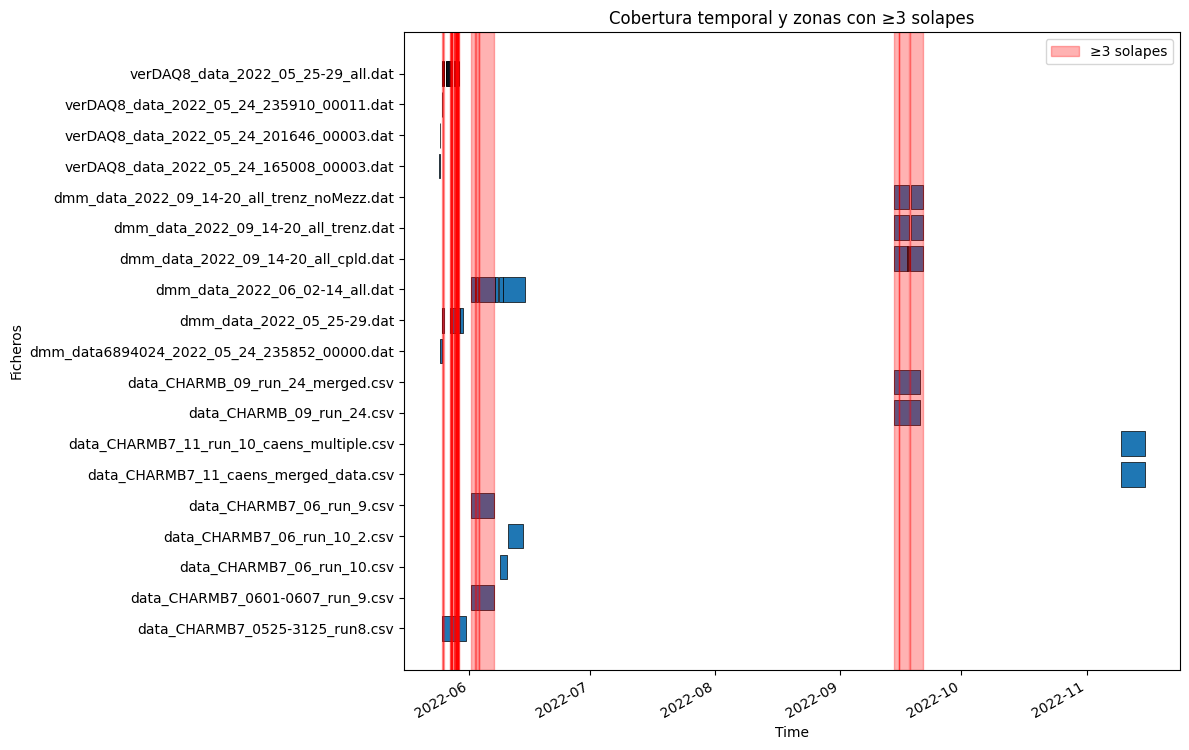

In [5]:
# Asumiendo que ya tienes:
#   time_intervals = build_time_intervals(all_files, gap_threshold_minutes=1)

# Grafica cobertura y solapes ≥3
plot_time_coverage(time_intervals, min_overlap=3)


In [6]:

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from pathlib import Path
from typing import List, Callable


def coincidence_time(df1, df2, data_labels, time_col="Time"):
    """
    Grafica eventos de df1 vs df2 y marca la zona de solape.
    Asume que ambas tablas ya tienen time_col en datetime64.
    """
    t1 = df1[time_col].sort_values()
    t2 = df2[time_col].sort_values()
    t_min = max(t1.min(), t2.min())
    t_max = min(t1.max(), t2.max())
    
    fig, ax = plt.subplots(figsize=(10,2))
    ax.axvspan(t_min, t_max, color="lightgrey", alpha=0.5, label="Zona de solape")
    ax.eventplot(t1, lineoffsets=1, linelengths=0.4, colors="tab:blue", label=data_labels[0])
    ax.eventplot(t2, lineoffsets=0, linelengths=0.4, colors="tab:orange", label=data_labels[1])
    ax.set_yticks([0,1]); ax.set_yticklabels([data_labels[1], data_labels[0]])
    ax.set_xlabel(time_col); ax.set_title(f"{data_labels[0]} vs {data_labels[1]}")
    ax.legend(loc="upper right")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()
    
    print(f"> Solape desde {t_min} hasta {t_max} ({t_max - t_min})\n")


def batch_overlap(
    file_list: List[Path],
    loader: Callable[[Path], pd.DataFrame],
    time_col: str = "Time",
    label_fmt: str = "{}",
):
    """
    Para cada par de archivos en file_list:
      - Carga con loader(path)
      - Convierte time_col a datetime
      - Llama a coincidence_time
    label_fmt puede incluir dos placeholders: label_fmt.format(name1, name2)
    """
    for f1, f2 in combinations(file_list, 2):
        df1 = loader(f1)
        df2 = loader(f2)
        df1[time_col] = pd.to_datetime(df1[time_col])
        df2[time_col] = pd.to_datetime(df2[time_col])
        
        name1 = f1.stem
        name2 = f2.stem
        print(f"\n=== Solape entre {name1} y {name2} ===")
        coincidence_time(
            df1, df2,
            data_labels=[label_fmt.format(name1), label_fmt.format(name2)],
            time_col=time_col
        )



In [7]:
# Convertir a Path si no lo son
beam_files      = [Path(p) for p in beam_files]
dmm_files       = [Path(p) for p in dmm_files]
dmm_cpld_files  = [Path(p) for p in dmm_cpld_files]
dmm_trenz_files = [Path(p) for p in dmm_trenz_files]
verdaq_files    = [Path(p) for p in verdaq_files]

# Solapes Beam (CSV)
batch_overlap(beam_files, loader=load_beam, time_col="Time", label_fmt="Beam:{}")

# Solapes DMM (.dat)
batch_overlap(dmm_files, loader=load_dmm, time_col="Time", label_fmt="DMM:{}")

# Solapes VerDAC (.dat)
batch_overlap(verdaq_files, loader=load_verdaq, time_col="Time", label_fmt="VerDAC:{}")

NameError: name 'load_beam' is not defined